# Can I predict popularity?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# import ipywidgets as widgets
# from ipywidgets import interact

In [3]:
# import chart_studio.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)

# import cufflinks as cf
# cf.go_offline(connected=True)
# cf.set_config_file(colorscale='plotly', world_readable=True)

## Songs dataset EDA

In [4]:
df = pd.read_csv('./data/data.csv')
print(df.shape)
df.head()

(174389, 19)


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


First, some cleaning:
- Drop duplicates
- Check for NaN
- Tokenize artists

In [5]:
# check for duplicated items, and drop them
print(f'{df.duplicated().sum()} duplicated tracks')
df = df.drop_duplicates()
df = df.reset_index(drop=True)

# check for NaN values
print(f'{df.isna().sum().sum()} NaN values')

# tokenize artist column
def tokenize_str(text):
    regex_rule = re.compile("['\"\[\]]")
    text = re.sub(regex_rule, "", text)
    return text.split(",")

df['artists'] = df['artists'].apply(tokenize_str)
print(df.shape)
df.head()

2159 duplicated tracks
0 NaN values
(172230, 19)


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,[Mamie Smith],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,[Screamin Jay Hawkins],0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,[Mamie Smith],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,[Oscar Velazquez],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,[Mixe],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [6]:
numerical_vars = df.select_dtypes(include=np.number).columns
categorical_vars = ['key', 'mode']
continuous_vars = [column for column in numerical_vars if column not in categorical_vars]

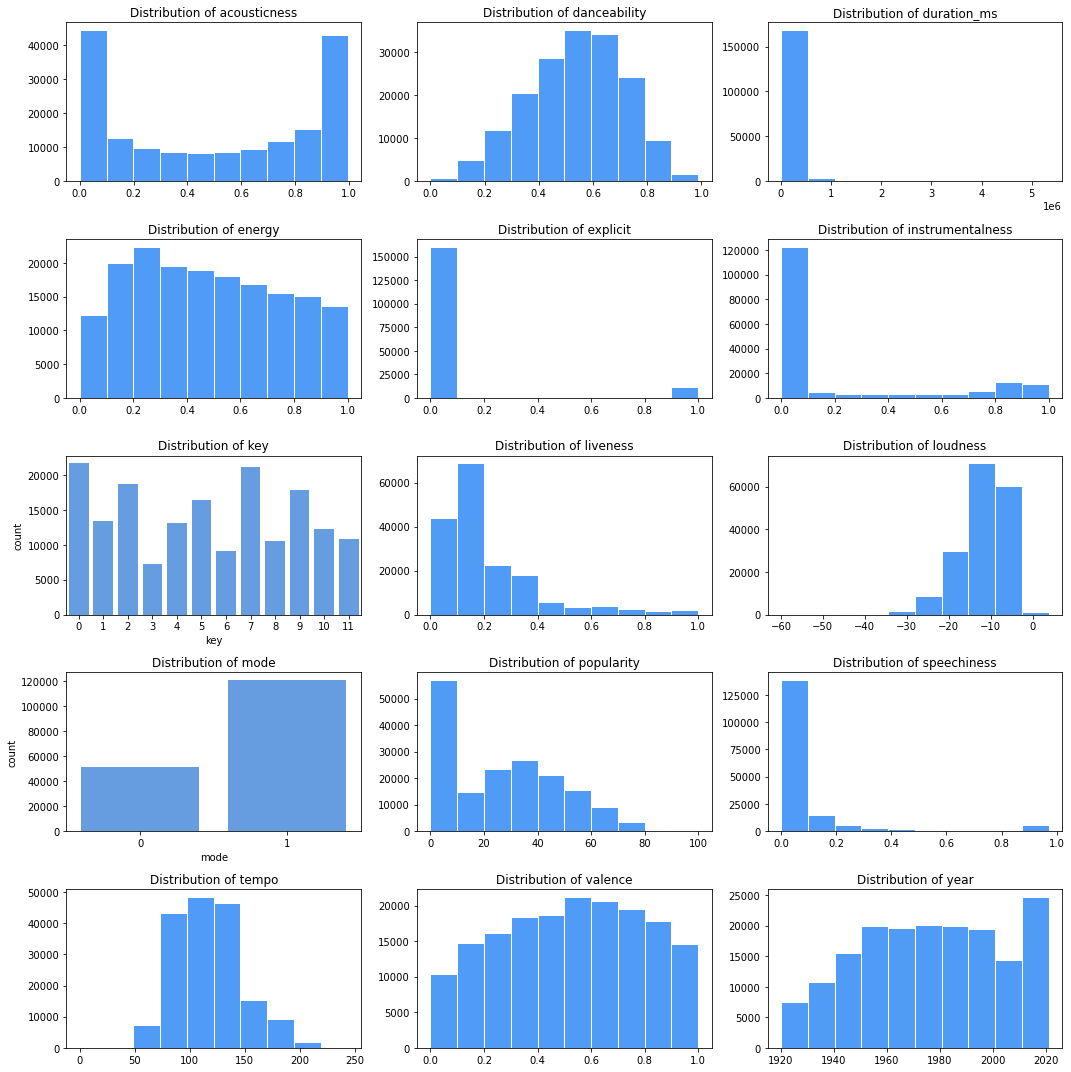

In [7]:
# Plot the distributions
colors = ['#509bf5', '#ff4632']
n_cols = 3
n_rows = int(np.ceil(len(numerical_vars)/ n_cols))

fig = plt.figure(figsize=(15, 15))

for i, variable in enumerate(numerical_vars):

    # make the plots
    ax = fig.add_subplot(n_rows,n_cols,i + 1)
    if variable in continuous_vars:
        ax.hist(df[variable], color=colors[0], edgecolor='white') 
    else:
        sns.countplot(x=variable, data=df, color=colors[0],ax=ax)
    
    plt.title(f'Distribution of {variable}')
    
plt.tight_layout()

In [8]:
# what is the proportion of 0 popularity vs. the rest of the data?
popularity_imbalance = df[df['popularity'] == 0].shape[0] / df.shape[0]
print(f'{popularity_imbalance*100:.2f}% of the artists have 0 popularity')

23.07% of the artists have 0 popularity


So, approximately a 23% of the data has popularity 0. The remaining 77% is split between 1 to 100!

## Preparation of the data

In [9]:
#i'm going to keep just the numeric values
df_numeric = df.set_index('id', verify_integrity=True).drop(['artists', 'name', 'release_date'], axis=1)
df_numeric

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
id,,,,,,,,,,,,,,,
0cS0A1fUEUd1EW3FcF8AEI,0.991000,0.598,168333,0.224,0,0.000522,5,0.3790,-12.628,0,12,0.0936,149.976,0.6340,1920
0hbkKFIJm7Z05H8Zl9w30f,0.643000,0.852,150200,0.517,0,0.026400,5,0.0809,-7.261,0,7,0.0534,86.889,0.9500,1920
11m7laMUgmOKqI3oYzuhne,0.993000,0.647,163827,0.186,0,0.000018,0,0.5190,-12.098,1,4,0.1740,97.600,0.6890,1920
19Lc5SfJJ5O1oaxY0fpwfh,0.000173,0.730,422087,0.798,0,0.801000,2,0.1280,-7.311,1,17,0.0425,127.997,0.0422,1920
2hJjbsLCytGsnAHfdsLejp,0.295000,0.704,165224,0.707,1,0.000246,10,0.4020,-6.036,0,2,0.0768,122.076,0.2990,1920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45XnLMuqf3vRfskEAMUeCH,0.795000,0.429,144720,0.211,0,0.000000,4,0.1960,-11.665,1,0,0.0360,94.710,0.2280,2021
4pPFI9jsguIh3wC7Otoyy8,0.795000,0.429,144720,0.211,0,0.000000,4,0.1960,-11.665,1,0,0.0360,94.710,0.2280,2021
52YtxLVUyvtiGPxwwxayHZ,0.795000,0.429,144720,0.211,0,0.000000,4,0.1960,-11.665,1,0,0.0360,94.710,0.2280,2021


In [10]:
#then, scale the features
from sklearn.preprocessing import StandardScaler

X = df_numeric.drop('popularity', axis=1)
y = df_numeric['popularity']

scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns, index = X.index)
df_scaled = df_scaled.assign(popularity=y.values)
df_scaled

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year,popularity
id,,,,,,,,,,,,,,,
0cS0A1fUEUd1EW3FcF8AEI,1.289127,0.351159,-0.437155,-0.944703,-0.270019,-0.583968,-0.058102,0.927729,-0.149421,-1.539048,-0.067174,1.090704,0.411326,-2.118494,12
0hbkKFIJm7Z05H8Zl9w30f,0.371872,1.795506,-0.560361,0.132378,-0.270019,-0.506250,-0.058102,-0.722324,0.793798,-1.539048,-0.286782,-0.992011,1.606526,-2.118494,7
11m7laMUgmOKqI3oYzuhne,1.294399,0.629793,-0.467771,-1.084393,-0.270019,-0.585483,-1.479429,1.702662,-0.056277,0.649752,0.372044,-0.638405,0.619351,-2.118494,4
19Lc5SfJJ5O1oaxY0fpwfh,-1.322485,1.101764,1.286995,1.165346,-0.270019,1.820066,-0.910898,-0.461614,0.785011,0.649752,-0.346328,0.365103,-1.827027,-2.118494,17
2hJjbsLCytGsnAHfdsLejp,-0.545383,0.953918,-0.458279,0.830826,3.703442,-0.584797,1.363224,1.055040,1.009084,-1.539048,-0.158950,0.169631,-0.855738,-2.118494,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45XnLMuqf3vRfskEAMUeCH,0.772512,-0.609844,-0.597595,-0.992492,-0.270019,-0.585536,-0.342368,-0.085218,0.019820,0.649752,-0.381837,-0.733814,-1.124279,1.663060,0
4pPFI9jsguIh3wC7Otoyy8,0.772512,-0.609844,-0.597595,-0.992492,-0.270019,-0.585536,-0.342368,-0.085218,0.019820,0.649752,-0.381837,-0.733814,-1.124279,1.663060,0
52YtxLVUyvtiGPxwwxayHZ,0.772512,-0.609844,-0.597595,-0.992492,-0.270019,-0.585536,-0.342368,-0.085218,0.019820,0.649752,-0.381837,-0.733814,-1.124279,1.663060,0


## Prediction models

In [11]:
# divide the dataset in two: train and test
from sklearn.model_selection import train_test_split

X = df_scaled.drop('popularity', axis=1)
y = df_scaled['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# and then, apply a linear regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)
coefs = pd.Series(lr.coef_, index=X.columns)

predictions_baseline = np.around(lr.predict(X_test)).astype(int)

Let's see how each feature is correlated with the popularity:

<ipython-input-13-fa04191856de>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ticks = ax.set_xticklabels(coefs.index, rotation=30)


Text(0.5, 1.0, 'Feature importance')

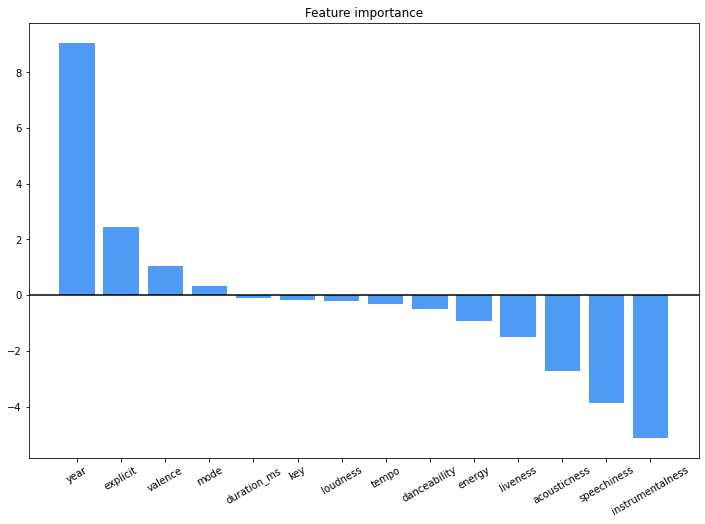

In [13]:
coefs = coefs.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(coefs.index, coefs.values, color=colors[0])
ax.axhline(0, color='black')
ticks = ax.set_xticklabels(coefs.index, rotation=30)
plt.title('Feature importance')

- As I saw when exploring the dataset, **year** of release is an important predictor for the popularity (given how Spotify estimates it)
- **Instrumentalness**, **speechiness** and **acousticness** also have a relative importance, confirming what I saw in previous EDAs

Let's see how accurate our models are:

In [14]:
from sklearn.metrics import log_loss, f1_score, precision_score, recall_score, accuracy_score, average_precision_score


def compute_classification_metrics(y_true, y_pred):
    metrics = {'accuracy':accuracy_score(y_true, y_pred),
               'precision':precision_score(y_true, y_pred, average='macro', zero_division=0),
               'recall':recall_score(y_true, y_pred, average='macro', zero_division=0),
               'f1':f1_score(y_true, y_pred, average='macro')}
    return metrics

In [15]:
metrics = {}
metrics['linear_regression'] = compute_classification_metrics(y_test, predictions_baseline)
metrics

{'linear_regression': {'accuracy': 0.026747179159650854,
  'precision': 0.015518516627968802,
  'recall': 0.01409139084958265,
  'f1': 0.010976003259627406}}

In [16]:
# try a logistic regression
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(class_weight='balanced', max_iter=1000)

logr.fit(X_train, y_train)

predictions_logr = pd.DataFrame({'prediction': logr.predict(X_test)}, index=X_test.index)

In [17]:
metrics['logistic_regression'] = compute_classification_metrics(y_test, predictions_logr)
metrics

{'linear_regression': {'accuracy': 0.026747179159650854,
  'precision': 0.015518516627968802,
  'recall': 0.01409139084958265,
  'f1': 0.010976003259627406},
 'logistic_regression': {'accuracy': 0.10404691401033501,
  'precision': 0.024657438996103433,
  'recall': 0.026553578591454918,
  'f1': 0.019183857046155852}}

Text(0.5, 1.0, 'Logistic Regression')

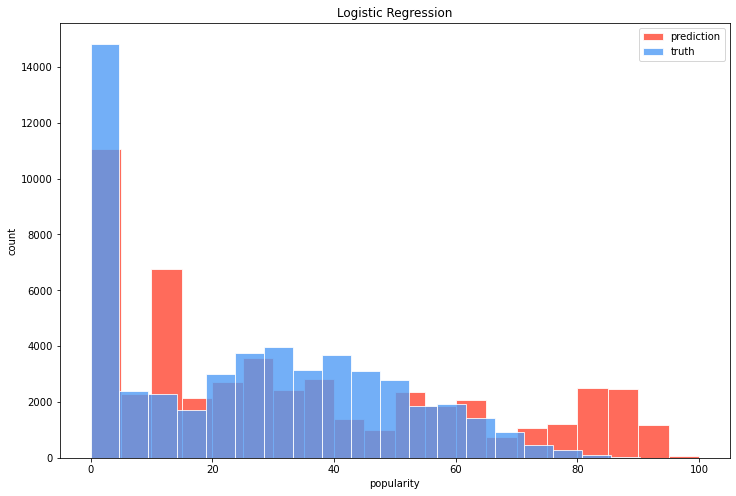

In [18]:
fig, ax = plt.subplots(figsize=(12,8))

plt.hist(predictions_logr, bins=20, alpha=0.8, label='prediction', color=colors[1], edgecolor='white')
y_test.hist(bins=20, alpha=0.8, label='truth', color=colors[0], edgecolor='white', ax=ax)
ax.set_xlabel('popularity')
ax.set_ylabel('count')
ax.grid(False)
ax.legend()
plt.title('Logistic Regression')

In [19]:
# try a random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', n_estimators=30, max_depth=3, min_samples_split=10)
rf.fit(X_train, y_train)

predictions_rf = rf.predict(X_test)
predictions_rf

array([86, 86, 56, ..., 42, 89, 86])

In [23]:
metrics['random_forest'] = compute_classification_metrics(y_test, predictions_rf)
pd.DataFrame(metrics)

,linear_regression,logistic_regression,random_forest
accuracy,0.026747,0.104047,0.051423
precision,0.015519,0.024657,0.023501
recall,0.014091,0.026554,0.018231
f1,0.010976,0.019184,0.010823


Text(0.5, 1.0, 'Random Forest')

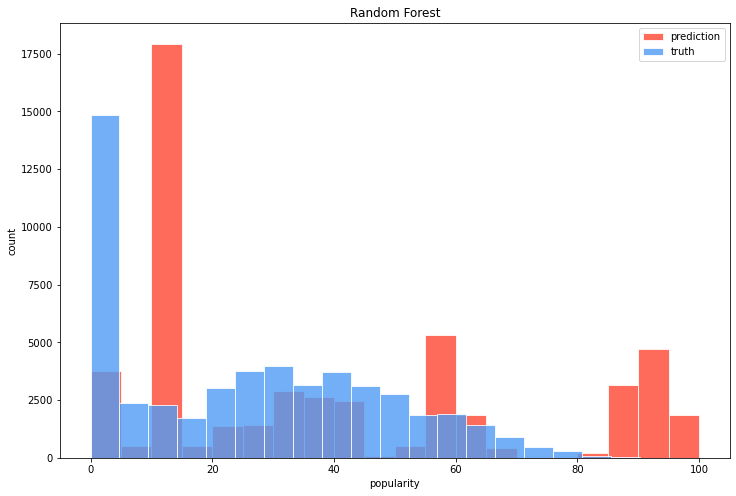

In [21]:
fig, ax = plt.subplots(figsize=(12,8))

plt.hist(predictions_rf, bins=20, alpha=0.8, label='prediction', color=colors[1], edgecolor='white')
y_test.hist(bins=20, alpha=0.8, label='truth', color=colors[0], edgecolor='white', ax=ax)
ax.set_xlabel('popularity')
ax.set_ylabel('count')
ax.grid(False)
ax.legend()
plt.title('Random Forest')

The prediction predicts too many songs with high popularity! And it doesn't predict the peak at 0 popularity...

In [22]:
# try XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
predictions_xgb = xgb.predict(X_test)


In [25]:
metrics['xgb'] = compute_classification_metrics(y_test, predictions_xgb)
pd.DataFrame(metrics)

,linear_regression,logistic_regression,random_forest,xgb
accuracy,0.026747,0.104047,0.051423,0.226287
precision,0.015519,0.024657,0.023501,0.045251
recall,0.014091,0.026554,0.018231,0.040972
f1,0.010976,0.019184,0.010823,0.041469


Text(0.5, 1.0, 'XGBoost')

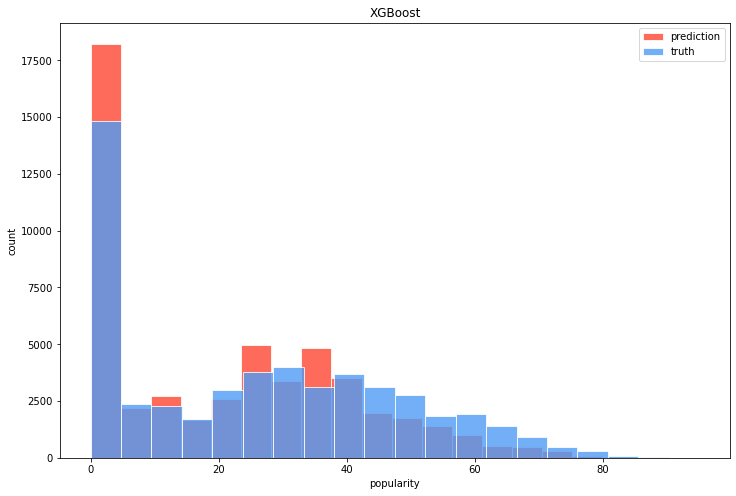

In [26]:
fig, ax = plt.subplots(figsize=(12,8))

plt.hist(predictions_xgb, bins=20, alpha=0.8, label='prediction', color=colors[1], edgecolor='white')
y_test.hist(bins=20, alpha=0.8, label='truth', color=colors[0], edgecolor='white', ax=ax)
ax.set_xlabel('popularity')
ax.set_ylabel('count')
ax.grid(False)
ax.legend()
plt.title('XGBoost')

These are the performances of all the models:

In [27]:
pd.DataFrame(metrics)

,linear_regression,logistic_regression,random_forest,xgb
accuracy,0.026747,0.104047,0.051423,0.226287
precision,0.015519,0.024657,0.023501,0.045251
recall,0.014091,0.026554,0.018231,0.040972
f1,0.010976,0.019184,0.010823,0.041469


All the values are very low!

Let's try with **Cohen Kappa score**: This is one of the best metrics for evaluating multi-class classifiers on imbalanced datasets.
The traditional metrics are biased towards the majority class and assumes an identical distribution of the actual and predicted classes. In contrast, Cohen’s Kappa Statistic measures the proximity of the predicted classes to the actual classes when compared to a random classification.

In [28]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_test, predictions_xgb)

0.1595962417506256

Aaaaand... it's very low again!! A value between 0-0.2 is slightly better than random chance

### What is going on?

Let's plot the predicted and true popularity, but with a count plot, instead of a histogram. This way, I'll see where each predicted popularity falls (a range between 0 and 100)

I will also use a logarithmic scale in the y axis, because the distribution is imbalanced and I can't *see* it clearly

Text(0.5, 1.0, 'XGBoost')

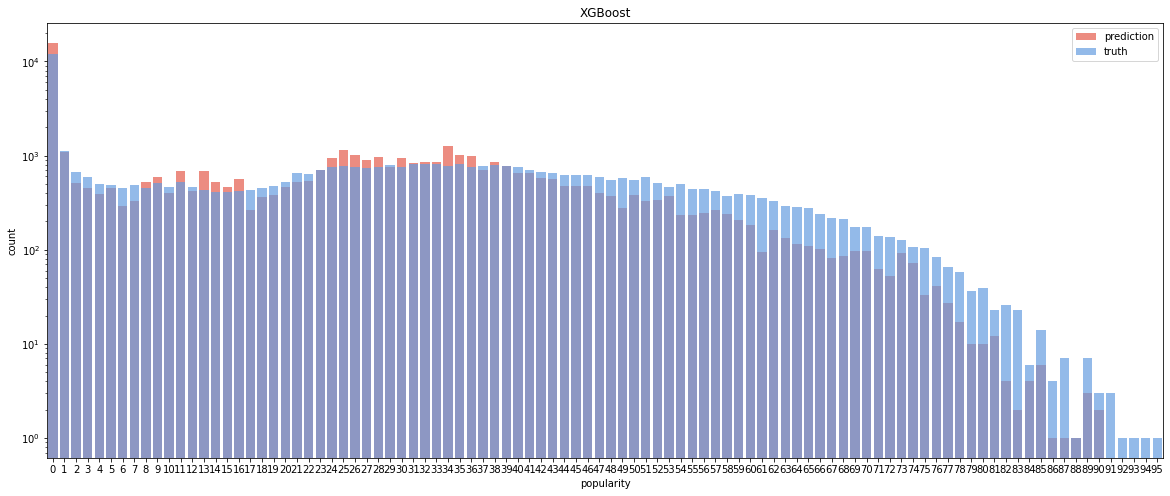

In [29]:
fig, ax = plt.subplots(figsize=(20,8))

sns.countplot(x=predictions_xgb, alpha=0.7, color=colors[1], label='prediction', ax=ax)
sns.countplot(x=y_test, alpha=0.7, color=colors[0], label='truth', ax=ax)

ax.set_xlabel('popularity')
ax.set_ylabel('count')

plt.yscale('log')
ax.grid(False)

ax.legend()
plt.title('XGBoost')

The models have low values in precision and recall because they are not matching every specific popularity, i.e, 1 to 100.

For example, we see a defect of songs predicted at popularity 22, but then an excess at popularity 24.

### Using metrics for continuous distributions (MSE)

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(f'xgboost - mean absolute error: {mean_absolute_error(y_test, predictions_xgb):.2f}')
print(f'xgboost - root mean squared error: {np.sqrt(mean_squared_error(y_test, predictions_xgb)):.2f}')

xgboost - mean absolute error: 9.71
xgboost - root mean squared error: 17.24


This imply that, in mean, a probability prediction deviates 17.24 points from the mean, which in a scale of 1-100 is not that bad

But, what is the mean absolute error for the highest popularities?

In [31]:
#first, convert the predictions into a datafrae
df_predictions = pd.DataFrame(predictions_xgb, index=y_test.index)

print(f'mean absolute error for popularity > 70: {mean_absolute_error(y_test[y_test > 70], df_predictions[y_test > 70]):.2f}')

mean absolute error for popularity > 70: 36.63


As the plot suggested, the MAE is much higher for the higher popularities.

### Reshaping the popularity to have less categories

In [32]:
# just 3 categories:

def re_bucket(pop):
    if pop < 20:    # not very popular
        pop = 0
    elif pop < 70:  # somewhat popular
        pop = 1
    else:           # very popular
        pop = 2
    return pop

df_scaled['popularity_3'] = df_scaled['popularity'].apply(re_bucket)

In [33]:
# divide in train and test
X = df_scaled.drop(['popularity', 'popularity_3'], axis=1)
y_reshaped = df_scaled['popularity_3']

X_train, X_test, y_train_reshaped, y_test_reshaped = train_test_split(X, y_reshaped, test_size=0.3, random_state=42)

In [34]:
xgb_reshaped = XGBClassifier()
xgb_reshaped.fit(X_train, y_train_reshaped)
predictions_xgb_reshaped = xgb_reshaped.predict(X_test)

In [35]:
compute_classification_metrics(y_test_reshaped, predictions_xgb_reshaped)

{'accuracy': 0.8859664402252801,
 'precision': 0.7797691042170808,
 'recall': 0.7139061775249723,
 'f1': 0.738331476890257}

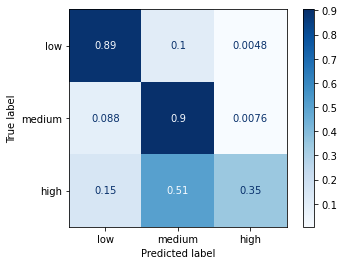

In [39]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(xgb_reshaped, X_test, y_test_reshaped, cmap='Blues', normalize='true',display_labels=['low', 'medium', 'high'])
plt.grid(False)

- The predictions for the low popularities (<20 and 20-70) are really accurate (0.89 and 0.9, respectively)
- But the prediction for the highest range of popularity (>70) is very poor, in more than half of the cases, the model mislabels a track as a medium popularity track

Text(0.5, 1.0, 'XGBoost')

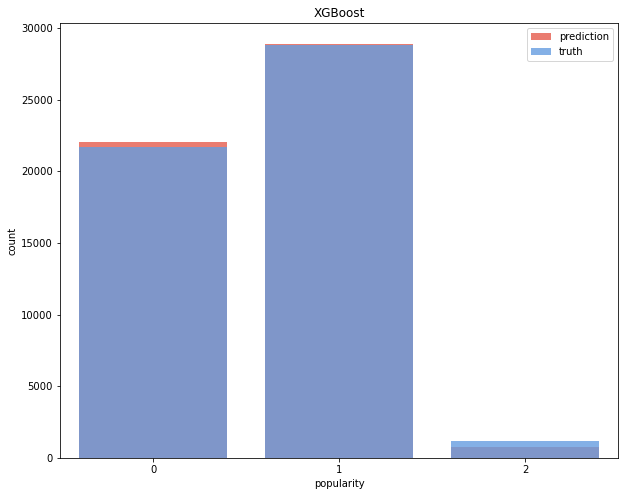

In [40]:
fig, ax = plt.subplots(figsize=(10,8))

sns.countplot(x=predictions_xgb_reshaped, alpha=0.8, color=colors[1], label='prediction', ax=ax)
sns.countplot(x=y_test_reshaped, alpha=0.8, color=colors[0], label='truth', ax=ax)

ax.set_xlabel('popularity')
ax.set_ylabel('count')

ax.grid(False)

ax.legend()
plt.title('XGBoost')

### Conclusions

- Low popularity and medium popularity is well predicted by the XGBoost model.
- The highest popularities are not well predicted. Adding a new variable that takes into account the “superstardom” of the artist may yield better results (see [Musical trends and
predictability of success in
contemporary songs in and
out of the top charts](https://royalsocietypublishing.org/doi/pdf/10.1098/rsos.171274), 2017)